Actor Critic Floater
---

In [1]:
import tensorflow as tf
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [2]:
class Floater:
    def __init__(self, mass = 1., g = 9.81, time_step = 0.1, init_velocity = np.array([0.,0.])):
        self.mass = mass
        self.time_step = time_step
        self.g = np.array([0.,-g])
        self.stopwatch = 0.
        
        self.position = np.array([0.,0.])        
        self.hist_position = [self.position]
        
        self.velocity = init_velocity
        self.hist_velocity = [self.velocity]
        
    ########
    # forces
    ########
        
    def apply_gravity(self):
        dv = self.g * self.time_step
        self.velocity = self.velocity + dv
        return self.velocity
        
    def apply_forces(self):
        self.apply_gravity()
        return self.velocity
        
    def update_history(self):
        self.hist_position.append(self.position)
        self.hist_velocity.append(self.velocity)
        return self.hist_position, self.hist_velocity
        
    #########
    # advance
    #########
        
    def advance(self):
#         self.apply_forces()
        self.position = self.position + self.velocity * self.time_step
        self.stopwatch = self.stopwatch + self.time_step
        self.update_history()
        return self.position
    
    def above_ground(self, ground_level = 0.):
        if self.position[1] > ground_level:
            return True
        else:
            return False
        
    #########
    # viewing
    #########
    
    def plot_trajectory(self, figsize = (12,12), color = 1., to_show = False, xlims = None, ylims=None, label = None):
        if to_show:
            plt.figure(figsize = figsize)
        positions = np.array(self.hist_position)
        x = positions[:,0]
        y = positions[:,1]
        plt.plot(x, y, color = str(color), label = label)
        if to_show:
            plt.show()
    
    def plot_velocity(self, figsize = (12,12), color = 1., to_show = False, xlims = None, ylims=None, label = None):
        if to_show:
            plt.figure(figsize = figsize)
        velocities = np.array(self.hist_velocity)
        x = velocities[:,0]
        y = velocities[:,1]
        plt.plot(x, y, color = str(color))
        if to_show:
            plt.show();

class Rocket(Floater):
    def __init__(self, isp = 800., fuel_rate = 0.01, dry_mass = 1., g = 9.81, time_step = 0.1, init_velocity = np.array([0.,0.]), wet_mass = 10.):
        super().__init__(mass = dry_mass, g = g, time_step = time_step, init_velocity = init_velocity)
        
        #################
        # engine and fuel
        #################
        
        self.dry_mass = dry_mass
        self.wet_mass = wet_mass
        self.fuel_rate = fuel_rate
        self.isp = isp
        self.fuel_empty = False
        
        #has warned already about a weak engine
        self.not_warned = True
        
        right = np.array([1,0])
        up = np.array([0,1])
        self.directions = {
            1:right,
            2:up,
            3:-right,
            4:-up
        }
        
    def fire(self, direction_code):
        direction = self.directions[direction_code]
        fuel_used = self.fuel_rate * self.time_step
        if fuel_used > self.wet_mass:
            fuel_used = self.wet_mass
        if self.wet_mass == 0. and not self.fuel_empty:
            self.fuel_empty = True
            print(f'Rocket out of fuel at {self.stopwatch}')
        self.wet_mass = self.wet_mass - fuel_used
        impulse = fuel_used * self.isp * np.linalg.norm(self.g) * direction
        dv = impulse/(self.wet_mass + self.dry_mass)
        self.velocity = self.velocity + dv
        if self.not_warned and not self.fuel_empty and np.linalg.norm(dv) < 2*np.linalg.norm(self.g*self.time_step):
            self.not_warned = not self.not_warned
            print(f'Warning: Rocket TWR is {np.linalg.norm(dv)/np.linalg.norm(self.g*self.time_step)}')
            if np.linalg.norm(dv) < np.linalg.norm(self.g*self.time_step):
                print(f'Rocket cannot support itself.')
                
        return self.velocity
    
    def get_state(self):
        state = [rocket.position, rocket.velocity, [rocket.dry_mass, rocket.wet_mass]]
        state = tf.convert_to_tensor(state)
        state = tf.reshape(state, (1,6))
        return state

        

Rocket out of fuel at 100.09999999999859
1499.9999999997312


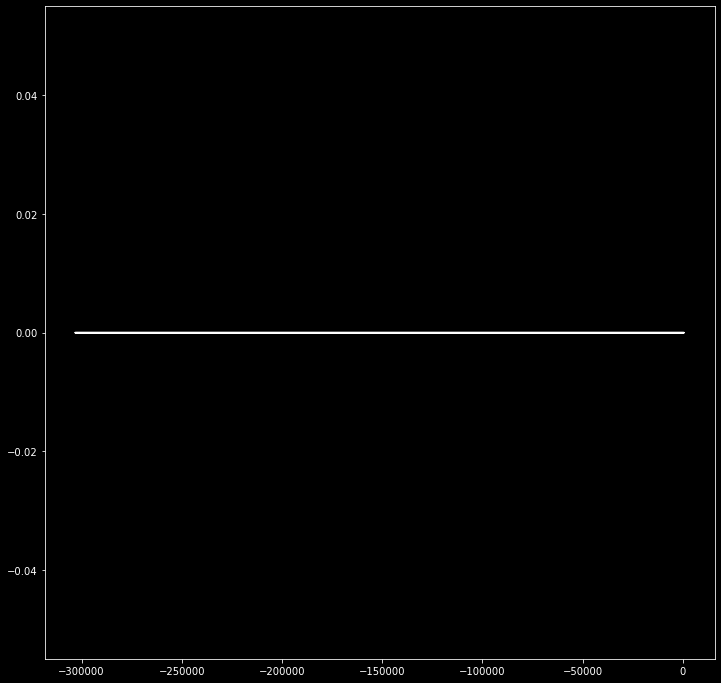

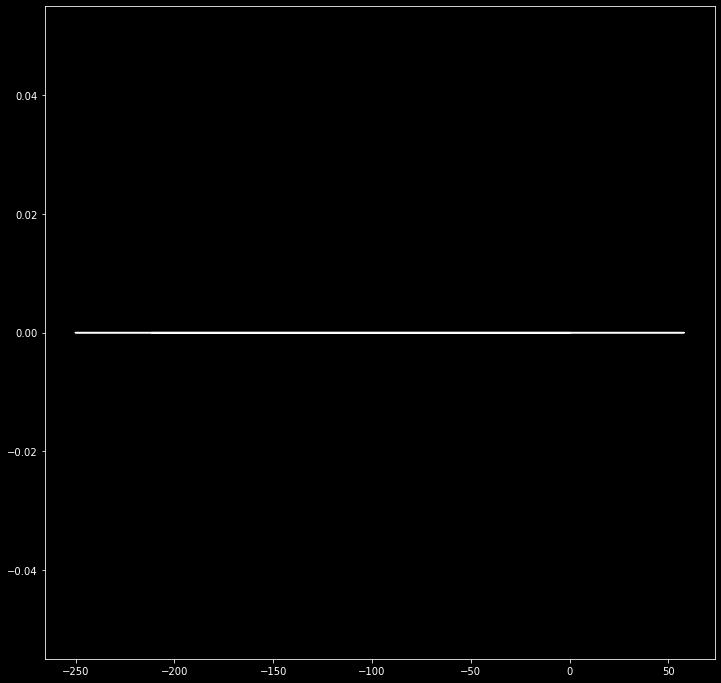

In [3]:
## see if the rocket is functioning properly

seed = 202231
rng = np.random.default_rng(seed)

vel = np.array([0.,0.])
flt = Rocket(init_velocity = vel, wet_mass=1)

prob_list = np.array(list(flt.directions.keys())[::-1])/sum(range(1,5))
prob_list = [0.5,0,0.5,0]

for step in range(15000):
    flt.advance()
    direction = rng.choice(range(1,5), p=prob_list )
    flt.fire(direction)
print(flt.stopwatch)
flt.plot_trajectory(to_show = True)
flt.plot_velocity(to_show = True)
    

In [43]:
seed =32854

class Pilot(tf.keras.Model):
    def __init__(self, num_outputs = 5, common_layer_size = 128):
        super().__init__()
        tf.random.set_seed(seed)
        self.common1 = tf.keras.layers.Dense(common_layer_size, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.actor = tf.keras.layers.Dense(num_outputs, activation='softmax')
        self.critic = tf.keras.layers.Dense(1)
        self.build( (1,6))

    def call(self, inputs, training=False):
        x = self.common1(inputs)
        if training:
            x = self.dropout(x, training=training)
        return tf.squeeze(self.actor(x)), tf.squeeze(self.critic(x))
    
class Pilot2(tf.keras.Model):
    def __init__(self, num_outputs = 5, common_layer_size = 32):
        super().__init__()
        tf.random.set_seed(seed)
        self.common1 = tf.keras.layers.Dense(common_layer_size, activation='relu')
        self.common2 = tf.keras.layers.Dense(common_layer_size, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.8)
        self.actor = tf.keras.layers.Dense(num_outputs, activation='softmax')
        self.critic = tf.keras.layers.Dense(1)

    def call(self, inputs, training=False):
        x = self.common1(inputs)
        x = self.common2(x)
        if training:
            x = self.dropout(x, training=training)
        return tf.squeeze(self.actor(x)), tf.squeeze(self.critic(x))

In [44]:
seed = 2022
rng = np.random.default_rng(seed)
eps = 1e-7

In [45]:
eps

1e-07

In [46]:
num_actions = 5
pilot = Pilot(num_outputs=num_actions)
# pilot = Pilot2(num_outputs=num_actions)

pilot.summary()

Model: "pilot_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            multiple                  896       
                                                                 
 dropout_6 (Dropout)         multiple                  0 (unused)
                                                                 
 dense_20 (Dense)            multiple                  645       
                                                                 
 dense_21 (Dense)            multiple                  129       
                                                                 
Total params: 1,670
Trainable params: 1,670
Non-trainable params: 0
_________________________________________________________________


In [47]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.00001, 1000, 0.1)
# learning_rate = 0.000001
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

#learning_rate = 0.0001
#optimizer = tf.optimizers.Adam(learning_rate = learning_rate,
#                              beta_1=0.999,
#                              beta_2=0.9)

Epoch 5, loss 311781.34, remaining fuel 9.993, time 30.00 sec
Epoch 10, loss 164714.94, remaining fuel 9.850, time 30.00 sec
Epoch 15, loss 71653.65, remaining fuel 9.850, time 30.00 sec
Epoch 20, loss 15918838.00, remaining fuel 9.850, time 30.00 sec
Epoch 25, loss 12542556.00, remaining fuel 9.850, time 30.00 sec
Epoch 30, loss 8873774.00, remaining fuel 9.850, time 30.00 sec
Epoch 35, loss 8259471.50, remaining fuel 9.850, time 30.00 sec
Epoch 40, loss 8670189.00, remaining fuel 9.850, time 30.00 sec
Epoch 45, loss 9259959.00, remaining fuel 9.850, time 30.00 sec
Epoch 50, loss 7463799.50, remaining fuel 9.850, time 30.00 sec


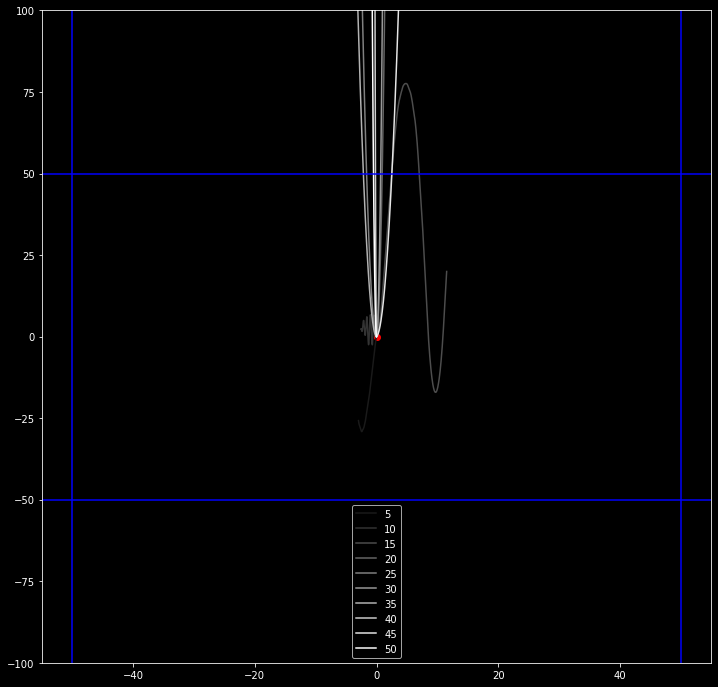

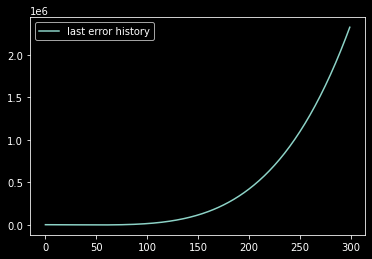

2    11645
0     1888
4     1398
1       42
3       27
dtype: int64

In [48]:
directions_dict = {0:'coast', 1:'right', 2:'up', 3:'left', 4:'down'}

huber = tf.losses.Huber()

target_altitude = 50.

num_epochs = 50
num_updates = 10
update_period = num_epochs // num_updates
epoch_count = 0.

max_time = 30.



plt.figure(figsize = (12,12))

all_action_history = []
for epoch in range(1,num_epochs+1):
    init_vel = rng.random(2) - np.array([0.5,0.5])
    rocket = Rocket(time_step = 0.1, fuel_rate=0.005, init_velocity=init_vel)
    rocket.not_warned = False
    state = rocket.get_state()
    with tf.GradientTape() as tape:
        errors_history = []
        critic_values_history = []
        action_probs_history= []
        while rocket.above_ground(-1000000.) and rocket.stopwatch < max_time:
            action_probs, critic_value = pilot.call(state, training=True)
            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            action_prob = action_probs[action]
            if action == 0:
                pass
            else:
                rocket.fire(action)
            all_action_history.append(action)
            rocket.advance()
            state = rocket.get_state()
            
            errors_history.append((rocket.position[1] - target_altitude)**2)
            critic_values_history.append(critic_value)
            action_probs_history.append(action_prob)
            
        losses = []
        discount_factor = 0.99
        running_discounted_sum = 0
        for error, critic_value, action_prob in zip(errors_history, critic_values_history, action_probs_history):
            critic_error = huber([error], [critic_value])
#             losses.append(discount_factor*(action_prob*critic_error + critic_error))
            step_loss = (-tf.math.log(action_prob)*critic_error + critic_error)
            losses.append(step_loss + discount_factor*running_discounted_sum)
            running_discounted_sum = step_loss + running_discounted_sum*discount_factor

        sum_losses = tf.reduce_mean(losses)
        grads = tape.gradient(sum_losses, pilot.trainable_variables)
        optimizer.apply_gradients(zip(grads, pilot.trainable_variables))

    if epoch%update_period == 0:
        rocket.plot_trajectory(color = epoch/num_epochs, label = str(epoch))#, rocket.plot_velocity(True, color = epoch/num_epochs)
        template = 'Epoch {}, loss {:.2f}, remaining fuel {:.3f}, time {:.2f} sec'
        print(template.format(epoch, sum_losses, rocket.wet_mass, rocket.stopwatch))
plt.legend();
# plt.xlim(-2000,2000)
plt.ylim(-100,100)
plt.axhline(-50, color = 'blue')
plt.axhline(50, color = 'blue')
plt.axvline(-50, color = 'blue')
plt.axvline(50, color = 'blue')
plt.scatter([[0]], [[0]], color = 'red')
plt.show()

plt.plot(errors_history, label = 'last error history')
# plt.plot(critic_losses, label = 'actor losses')
# plt.plot(actor_losses, label = 'critic_losses')
plt.legend()
plt.show();

# pd.Series(all_action_history).replace(directions_dict).value_counts()[directions_dict.values()]
pd.Series(all_action_history).value_counts()